# To run this, you need to run (or have run) the following in docker:
```
pip install textblob
pip install nltk
pip install twitterscraper
```

In [1]:
from twitterscraper import query_tweets
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
import hypertools as hyp
import numpy as np
from textblob import TextBlob as tb
import nltk
import datetime as dt
nltk.download('brown')
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Exploring twitter data

Scrape twitter for a keyword, fit topic models, do sentiment analyses on the tweets, and make a plot

In [2]:
#scrape twitter for most recent tweets on the election...this will take a while
n_tweets = 50
tweets = []
for tweet in query_tweets("election", n_tweets)[:n_tweets]:
    tweets.append(tweet)

In [4]:
tweets[0].timestamp

datetime.datetime(2017, 10, 10, 18, 26, 59)

In [5]:
#get the tweet text
tweet_text = list(map(lambda x: x.text, tweets))

In [8]:
tweet_text[1]

'There will be no election on 26th and no one will be declared President without a fresh election..'

In [9]:
#convert the data to a useable format
n_features = 1000
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweet_text)
tf_feature_names = tf_vectorizer.get_feature_names()

In [10]:
tf_feature_names

['10',
 '2017',
 '26th',
 'abc',
 'abcpolitics',
 'amendment',
 'best',
 'boycotted',
 'campaign',
 'candidate',
 'close',
 'com',
 'court',
 'day',
 'does',
 'election',
 'elections',
 'fair',
 'fb',
 'free',
 'going',
 'html',
 'http',
 'https',
 'iebc',
 'just',
 'kenyan',
 'latest',
 'liberia',
 'liberian',
 'lnjx_imoz3m',
 'make',
 'million',
 'new',
 'obama',
 'october',
 'odinga',
 'passes',
 'people',
 'pic',
 'place',
 'poll',
 'polls',
 'presidential',
 'press',
 'raila',
 'russian',
 'senate',
 'state',
 'status',
 'today',
 'trump',
 'twitter',
 'unanimously',
 'update',
 'vote',
 'wait',
 'wants',
 'web',
 'withdrawal',
 'won',
 'www',
 'youtu',
 'youtube']

In [11]:
#fit a topic model to the tweets
n_topics = 10
lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
tweet_topics = lda.fit(tf)

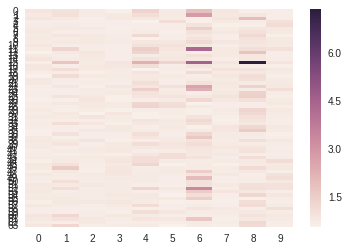

In [12]:
#topic vectors for each tweet
sns.heatmap(tweet_topics.components_.T)

In [13]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic ' + str(topic_idx) + ': ', end='')
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [14]:
display_topics(lda, tf_feature_names, 10)

Topic 0: does 26th won 10 elections close fair going trump html
Topic 1: election russian com youtube won free fair new twitter today
Topic 2: people make kenyan court new october day trump www wait
Topic 3: election press senate lnjx_imoz3m elections state russian http wait october
Topic 4: election com https liberia twitter 10 court raila latest boycotted
Topic 5: election polls abc liberia presidential latest http close just pic
Topic 6: election com twitter 2017 http https status 10 www passes
Topic 7: fair just 26th election unanimously obama place candidate free october
Topic 8: election 26th court october just iebc http liberian update obama
Topic 9: abcpolitics press https status web abc com state trump twitter


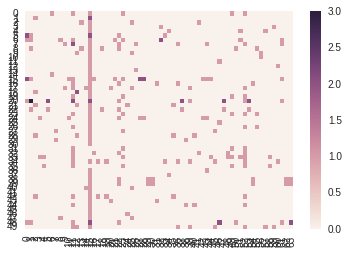

In [15]:
sns.heatmap(tf.todense())

In [16]:
blob = tb(tweet_text[0])

In [18]:
def tweet_sentiment(tweet):
    b = tb(tweet)
    return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))

In [19]:
sentiments = list(map(tweet_sentiment, tweet_text))

In [22]:
#happiest tweet
tweet_text[np.where(sentiments == np.max(sentiments))[0][0]]

"The ALP's greatest asset for 2019 Election.  In the meantime just sit back and let @TonyAbbottMHR campaign for them.  A great strategy..."

In [23]:
#saddest tweet
tweet_text[np.where(sentiments == np.min(sentiments))[0][0]]

'@K24 Tv am watching from Roisambu Nairobi i think IEBC should go with OCTOBER 26th election so as to hard here to the Supreme Court order'

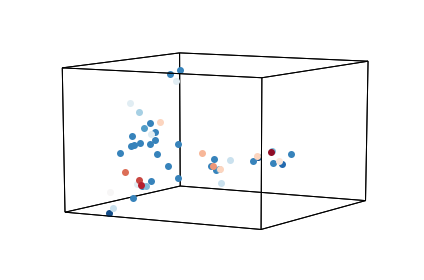

In [25]:
#make a hypertools plot of the tweets, colored by sentiment
hyp.plot(tweet_topics.components_.T, 'o', group=sentiments, palette='RdBu_r', model='SpectralEmbedding');

# Defining some useful Twitter-related functions

In [26]:
# function for scraping twitter for one or more keywords and returning a dictionary with:
# - tweets: the tweet text (list of length n_tweets)
# - topicvecs: the tweet topic vectors (numpy array with n_tweets rows and n_topics columns)
# - topwords: the top n words from each topic (list of length n_topics, where each element is a list of n_words)
# - sentiments: the sentiment valence of each tweet (numpy array of length n_tweets)

def twitter_magic(keywords, n_tweets=500, n_topics=10, n_words=5, model=None):
    #if keywords is a list, combine all keywords into a single string, where each word is separated by " OR "
    if type(keywords) == list:
        keywords = ' OR '.join(keywords)
    
    #get the tweets
    tweets = []
    for tweet in query_tweets(keywords, n_tweets)[:n_tweets]:
        tweets.append(tweet)
    
    #get the tweet text
    tweet_text = list(map(lambda x: x.text, tweets))
    
    #fit a topic model to the tweet text    
    n_features = 1000
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(tweet_text)    
    vocab = tf_vectorizer.get_feature_names()
    
    if model == None:
        lda = LDA(n_topics=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0).fit(tf)
    else:
        lda = model            
    tweet_topics = lda.fit(tf)
    
    def get_top_words(model, vocab, n_words):
        top_words = []
        for topic_idx, topic in enumerate(model.components_):       
            next = topic.argsort()[:-n_words - 1:-1]
            top_words.append(list(map(lambda x: vocab[x], next)))
        return top_words
    
    def tweet_sentiment(tweet):
        b = tb(tweet)
        return np.sum(np.array(list(map(lambda x: x.sentiment.polarity, b.sentences))))
    
    return{'tweets': tweet_text,
           'topicvecs': lda.components_.T,
           'topwords': get_top_words(lda, vocab, n_words),
           'sentiments': np.array(list(map(tweet_sentiment, tweet_text))),
           'model': lda}

In [27]:
n = 100 #number of tweets to download for each candidate

trump = twitter_magic(['election AND trump'], n_tweets=n)

#now fit clinton tweets using the topic model from trump_election_tweets (otherwise the topic vectors will be different)
clinton = twitter_magic(['election AND clinton', 'election AND hillary'], n_tweets=n, model=trump['model'])

#now fit sanders tweets (using the same topic model)
sanders = twitter_magic(['election AND sanders', 'election AND bernie'], n_tweets=n, model=trump['model'])

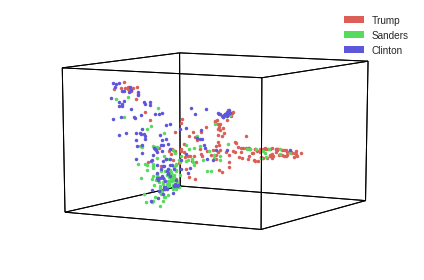

In [28]:
#plot the trump and clinton tweets
hyp.plot([trump['topicvecs'], sanders['topicvecs'], clinton['topicvecs']],
         '.', model='SpectralEmbedding', legend=['Trump', 'Sanders', 'Clinton']);

In [29]:
#get the happiest and saddest tweets from each candidate
def get_happiest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.max(results['sentiments']))[0][0]]

def get_saddest_tweets(results):
    return results['tweets'][np.where(results['sentiments'] == np.min(results['sentiments']))[0][0]]

candidates = ['trump', 'sanders', 'clinton']

print('HAPPIEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_happiest_tweets(eval(c)) + '\n')
    
print('\n\nSADDEST TWEETS:')
for c in candidates:
    print(c.upper() + '-CONTAINING: ' + get_saddest_tweets(eval(c)) + '\n')

HAPPIEST TWEETS:
TRUMP-CONTAINING: You know how to get Trump out, right? Win an election. pic.twitter.com/0LJCEVCrU4

SANDERS-CONTAINING: He couldn’t win with a stacked deck.  May be should hire Wasserman-Schultz.  She is good a tilting primary election results.  Ask Bernie!

CLINTON-CONTAINING: 2016 Primary Election was rigged!
" #BernieWouldHaveWon "
Super Delegates  BEFORE 1st States voted
Hillary: 714
Sanders: 39
#BERNIE2020 



SADDEST TWEETS:
TRUMP-CONTAINING: Do that and you’ll destroy the Republican Party! Once party is destroyed and wiped out 2018 election will be brutal Dems will impeach Trump

SANDERS-CONTAINING: How did the DNC rig the election? Do you mean against Bernie? I get what you’re trying to say w trump but imo I feel he is as corrupt as they are.

CLINTON-CONTAINING: Ohh and I did voted Trump during the spring primaries (bc of bad dem options)But yes, I voted Hillary during the general election. (my bad)

